# Introduction
---

# Import libries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

# Load the data
---
이번에는 이미지를 불러와야 합니다. 다른 종류의 데이터를 다루는 것과 크게 다른 점은 없습니다만 이미지와 관련된 라이브러리를 사용한 경험이 없어 막막할 수도 있겠습니다. [sci-kit image](https://scikit-image.org/)를 사용하면 간단하게 처리할 수 있습니다. 먼저, 첫 번째 이미지를 불러와보겠습니다.

In [2]:
from skimage import io

io.imread('./data/train/cat.0.jpg')

array([[[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        ...,
        [240, 201, 122],
        [239, 200, 121],
        [238, 199, 120]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        ...,
        [241, 202, 123],
        [240, 201, 122],
        [238, 199, 120]],

       [[203, 164,  87],
        [203, 164,  87],
        [204, 165,  88],
        ...,
        [241, 202, 123],
        [240, 201, 122],
        [239, 200, 121]],

       ...,

       [[153, 122,  55],
        [153, 122,  55],
        [153, 122,  55],
        ...,
        [  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0]],

       [[152, 121,  54],
        [152, 121,  54],
        [152, 121,  54],
        ...,
        [  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0]],

       [[151, 120,  53],
        [151, 120,  53],
        [151, 120,  53],
        ...,
        [  1,   1,   0],
        [  1,   1,   0],
        [  1,   1,   0]]

skimage.io.imread()를 사용하면 수치 데이터로 표현된 이미지의 모습(?)을 확인할 수 있습니다. 해당 이미지를 보고 싶다면 skimage.io.imshow() 함수나 matplotlib와 같은 시각화 라이브러리를 사용합니다(~~왠지 모르게 긴급한 상황에 처한 것 같은 고양이의 모습을 볼 수 있습니다~~). 더 자세한 설명은 [여기](https://matplotlib.org/users/image_tutorial.html)를 참고하시기 바랍니다.

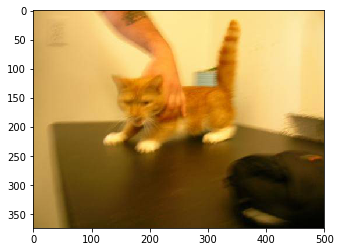

In [3]:
import matplotlib.pyplot as plt

plt.imshow(io.imread('./data/train/cat.0.jpg'))

In [38]:
from os.path import join, isfile
from os import listdir
from sklearn.preprocessing import LabelEncoder

image_list = np.array([[f, f[:3] ]for f in listdir('./data/train/') if isfile(join('./data/train/', f))])
label = image_list[:,1]
label_encoder = LabelEncoder()
label = label_encoder.fit_transform(label)
type(label)

numpy.ndarray

이번에는 배치(batch) 단위의 학습을 손쉽게 진행하기 위해 PyTorch에서 제공하는 추상 클래스(abstract class)인 Dataset을 사용해보겠습니다. 먼저, 사용자가 새로 정의한 Dataset을 사용하려면, torch.utils.data.Dataset을 상속받아 \__len\__과 \__getitem\__을 재정의(override)해야 합니다.

In [39]:
from os import listdir
from os.path import join, isfile
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

class CatDogDataset(Dataset):
    def __init__(self, data_path, transform=None):
        data = np.array([[f, f[:3] ]for f in listdir(data_path) if isfile(join(data_path, f))])
        lable_encoder = LabelEncoder()
        
        self.data_path = data_path
        self.image_list = data[:,0]
        self.label_list = label_encoder.fit_transform(data[:,1])
        self.transform = transform
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = join(self.data_path, self.image_list[idx])
        image = io.imread(img_name)
        sample = {'image': image, 'label': self.label_list[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample

CatDogDataset 클래스를 사용해 4장의 이미지를 확인해보겠습니다.

0 (375, 499, 3)
1 (332, 500, 3)
2 (374, 500, 3)
3 (374, 500, 3)


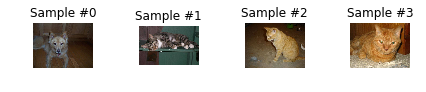

In [40]:
dataset = CatDogDataset(data_path='./data/train/')

fig = plt.figure()

for i in range(len(dataset)):
    sample = dataset[i]
    
    print(i, sample['image'].shape)
    
    ax = plt.subplot(1, 4, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'])
    
    if i == 3:
        plt.show()
        break

# Data preprocessing
---
위의 결과를 보면 이미지의 크기가 제각각임을 알 수 있습니다. [여기](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=dataset)를 참고해 고정된 크기의 이미지로 맞춰주는 코드를 작성합니다.

In [41]:
from skimage import transform

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
            
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img, 'label': label}

In [42]:
class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h, left: left + new_w]
        
        return {'image': image, 'label': label}

In [49]:
class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'label': torch.tensor(label, dtype=torch.long)}

/home/ultron/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


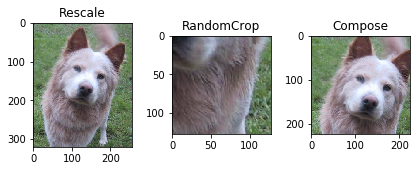

In [50]:
from torchvision import transforms, utils

scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), RandomCrop(224)])

fig = plt.figure()
sample = dataset[756]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    plt.imshow(transformed_sample['image'])

plt.show()

In [52]:
transformed_dataset = CatDogDataset(data_path='./data/train/', 
                                    transform=transforms.Compose([
                                        Rescale(256), 
                                        RandomCrop(224), 
                                        ToTensor()
                                    ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]
    
    print(i, sample['image'].size(), sample['label'])
    
    if i == 3:
        break

0 torch.Size([3, 224, 224]) 1
1 torch.Size([3, 224, 224]) 0
2 torch.Size([3, 224, 224]) 0
3 torch.Size([3, 224, 224]) 0


/home/ultron/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [53]:
dataloader = DataLoader(transformed_dataset, 
                        batch_size=32, 
                        shuffle=True)

# Build the model
---
이번에는 2개의 컨볼루션층(convolutional layer)과 1개의 완전연결층(fully connected layer)으로 구성된 모델을 만들어보도록 하겠습니다. 첫 번째 층에서는 크기가 3\*3인 필터 32개를 만들고 최대 풀링(max pooling)을 해줍니다. 두 번째 층에서도 필터를 64개 만들어낸다는 점만 빼고 첫 번째 층과 동일한 과정을 거칩니다. 그리고 마지막에 분류를 위해 완전연결층을 쌓아줍니다.

In [6]:
class CNN(nn.Module):
    def __init__(self, n_classes=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=0),  
                                   nn.ReLU(), 
                                   nn.BatchNorm2d(32), 
                                   nn.MaxPool2d(2, stride=2)
                                  )
        self.conv2 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0), 
                                   nn.BatchNorm2d(64),
                                   nn.ReLU(), 
                                   nn.MaxPool2d(2, stride=2)
                                  )
        self.fc = nn.Sequential(nn.Linear(reshape, 128), nn.ReLU(), nn.Linear(128, n_classes), nn.Softmax())
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.reshape(out.size(0), -1) # 완전연결층에 맞게 펼쳐주는 역할
        out = self.fc(out)

구성요소에 대해 설명하도록 하겠습니다.
## Convolutional Layer
---
## ReLU Activation
---
ReLU(Rectified Linear Unit)는 아래 그림과 같은 형태의 활성함수입니다. 양의 영역이 선형이기 때문에 포화현상이 발생하지 않으며, 음의 영역은 모두 0이 되므로 신경망이 희소해지게 됩니다.

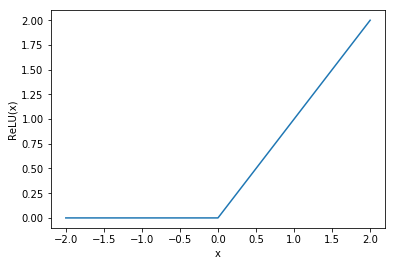

In [29]:
x = range(-2,3)
y = nn.functional.relu(torch.tensor(x)).tolist()
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.show()

## Batch Normalization
---
인공신경망이 깊어짐에 따라 학습이 힘들어지는 이유 중 하나는 학습이 진행됨에 따라 가중치가 갱신되기 때문에 각 층의 입력값 분포가 변화하기 때문입니다. 다시 말해, 첫 번째 층에는 트레이닝 데이터가 아무런 변환도 없이 그대로 입력되지만 두 번째 층부터는 학습이 진행되면서 갱신되는 가중치에 의해 변형된 트레이닝 데이터가 전달되게 되는 것입니다. 이처럼 학습 도중에 샘플의 분포가 바뀌는 현상을 covariate shift라고 합니다. 층이 깊어질수록 원래의 트레이닝 데이터가 더욱 변형되므로, covariate shitf 현상이 심해집니다.

In [7]:
classifier = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters())

NameError: name 'reshape' is not defined

# Train the model